# Read Data from DB

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#To use the data simply 
# Import SQL module
import sqlite3
# Create a connection to the database file
con = sqlite3.connect(r"/content/drive/Shared drives/Module 3 Team A/scraped_data/scriptanalyser_final.db") # refer to this .db file
#Create a cursor
cursor = con.cursor()

In [3]:
#res = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#for name in res:
 #   print (name[0])
 #cursor.fetchall()   

In [4]:
# Run SQL statements
query = """select  a.title as IMSDB_title, a.genres, a.script,
            b.TMDB_title, b.budget, b.runtime, b.TMDB_genres,b.vote_average,
            b.TMDB_release_date, b.popularity, b.TMDB_original_title,
            b.imdb_id,b.TMDB_Rating,b.TMDB_revenue,b.TMDB_vote_count,b.TMDB_id 
            from IMSDB a 
             inner join TMDB b
             on (trim(upper(a.title)) = trim(upper(b.TMDB_title)))
             """

In [5]:
import pandas as pd
post = pd.read_sql_query(sql=query, con = con)
post

,IMSDB_title,genres,script,TMDB_title,budget,runtime,TMDB_genres,vote_average,TMDB_release_date,popularity,TMDB_original_title,imdb_id,TMDB_Rating,TMDB_revenue,TMDB_vote_count,TMDB_id
0,10 Things I Hate About You,"['Comedy', 'Romance']",\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,10 Things I Hate About You,16000000,97,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",7.5,1999-03-30,32.475,10 Things I Hate About You,tt0147800,PG-13,53478166,5348,4951
1,12,['Comedy'],\n\n\n \n 12 - Script\n\n\n\n\nCUT FROM BLAC...,12,4000000,159,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",7.2,2007-06-06,8.862,12,tt0488478,,7537453,141,20714
2,12 and Holding,['Drama'],\n \n \n \n ...,12 and Holding,400000,90,"[{'id': 18, 'name': 'Drama'}]",7.0,2006-03-31,8.202,12 and Holding,tt0417385,,95687,49,18164
3,12 and Holding,['Drama'],\n \n \n \n ...,12 and Holding,400000,90,"[{'id': 18, 'name': 'Drama'}]",7.0,2006-03-31,8.202,12 and Holding,tt0417385,,95687,49,18164
4,12 Years a Slave,['Drama'],\n\n\n 12 YEARS A ...,12 Years a Slave,20000000,134,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",8.0,2013-10-18,20.061,12 Years a Slave,tt2024544,R,187000000,8368,76203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,You've Got Mail,"['Comedy', 'Romance']",\n\n\nYou've Got Mail\n\n\n\t\t\tYou've Got Ma...,You've Got Mail,65000000,119,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",6.6,1998-02-26,16.899,You've Got Mail,tt0128853,PG,250821495,2188,9489
1188,Youth in Revolt,"['Comedy', 'Drama', 'Romance']",\n \n \n\n ...,Youth in Revolt,18000000,87,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",6.1,2009-09-11,13.05,Youth in Revolt,tt0403702,R,0,632,22327
1189,Zero Dark Thirty,"['Drama', 'Thriller']",\n\n \n ZERO D...,Zero Dark Thirty,40000000,157,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",6.9,2012-12-19,16.987,Zero Dark Thirty,tt1790885,R,132820716,3151,97630
1190,Zerophilia,"['Comedy', 'Romance']",\n\n\n\n ...,Zerophilia,325000,90,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",5.3,2005-10-13,5.612,Zerophilia,tt0421090,,0,29,30548


In [6]:
#con.close() #Close connection at the end of session

#Data Formatting

In [7]:
#Define target columns
y_columns = ['TMDB_revenue','vote_average']

In [8]:
# Remove rows with missing target
post.dropna(axis=0, subset=y_columns, inplace=True)

In [9]:
#Remove columns with high cardinality
post = post.drop(["genres","IMSDB_title", "TMDB_title", "TMDB_genres", "imdb_id", "TMDB_id", "TMDB_release_date", "popularity", "TMDB_Rating", "TMDB_vote_count", "TMDB_original_title"], axis=1)

In [10]:
post

,script,budget,runtime,vote_average,TMDB_revenue
0,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,16000000,97,7.5,53478166
1,\n\n\n \n 12 - Script\n\n\n\n\nCUT FROM BLAC...,4000000,159,7.2,7537453
2,\n \n \n \n ...,400000,90,7.0,95687
3,\n \n \n \n ...,400000,90,7.0,95687
4,\n\n\n 12 YEARS A ...,20000000,134,8.0,187000000
...,...,...,...,...,...
1187,\n\n\nYou've Got Mail\n\n\n\t\t\tYou've Got Ma...,65000000,119,6.6,250821495
1188,\n \n \n\n ...,18000000,87,6.1,0
1189,\n\n \n ZERO D...,40000000,157,6.9,132820716
1190,\n\n\n\n ...,325000,90,5.3,0


In [11]:
post.isna().sum()

script          0
budget          0
runtime         0
vote_average    0
TMDB_revenue    0
dtype: int64

#Data Cleaning / Preprocessing

In [12]:
# Let's take a look at the first script
post.script.loc[0]

'\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.location.href=location.href\n<b>// -->\n</b>\nTen Things I Hate About You - by Karen McCullah Lutz & Kirsten Smith\n\n                               TEN THINGS I HATE ABOUT YOU\n          \n                written by Karen McCullah Lutz & Kirsten Smith\n          \n              based on \'Taming of the Shrew" by William Shakespeare\n          \n          Revision November 12, 1997\n          \n          \n          PADUA HIGH SCHOOL - DAY\n          \n          Welcome to Padua High School,, your typical urban-suburban \n          high school in Portland, Oregon.  Smarties, Skids, Preppies, \n          Granolas. Loners, Lovers, the In and the Out Crowd rub sleep \n          out of their eyes and head for the main building.\n          \n          PADUA HIGH PARKING LOT - DAY\n          \n          KAT STRATFORD, eighteen, pretty -- but trying hard not to be \n          -- in a baggy granny dress and glasses, balances a cup of \n          cof

In [13]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [14]:
# Let's take a look at the updated text
post_script = pd.DataFrame(post.script.apply(round1))

data_clean = pd.concat([post_script], axis=1, ignore_index=False)
data_clean.columns = ["script"]
data_clean

,script
0,\n\n\n\nb\nbif window top\ntoplocationhrefloca...
1,\n\n\n \n script\n\n\n\n\ncut from black\n...
2,\n \n \n \n ...
3,\n \n \n \n ...
4,\n\n\n years a sl...
...,...
1187,\n\n\nyouve got mail\n\n\n\t\t\tyouve got mail...
1188,\n \n \n\n ...
1189,\n\n \n zero d...
1190,\n\n\n\n ...


In [15]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [16]:
# Let's take a look at the updated text
post_script2 = pd.DataFrame(data_clean.script.apply(round2))
#post_TMDB_Rating2 = pd.DataFrame(data_clean.TMDB_Rating.apply(round2))

data_clean2 = pd.concat([post_script2], axis=1, ignore_index=True)
data_clean2.columns = ["script"]
data_clean2

,script
0,bbif window toptoplocationhreflocationhrefb bt...
1,scriptcut from blacktitle finexterior l...
2,...
3,...
4,years a slave ...
...,...
1187,youve got mail\t\t\tyouve got mail\t\t\tby nor...
1188,you...
1189,zero dark th...
1190,zerophi...


In [17]:
# We've now created a corpus - a collection of texts, and they are all put
# together neatly in a pandas dataframe.

We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean2.script)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaargh,aaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhh,aaaaaaaaaaaaaaaiiiighgru,aaaaaaaaaaaaaah,aaaaaaaaaaaaaahhhhhhhhhhhh,aaaaaaaaaaaagggh,aaaaaaaaaaaaghbut,aaaaaaaaaaaah,aaaaaaaaaaaanimal,aaaaaaaaaaahhhhhhhhh,aaaaaaaaaahhh,aaaaaaaaahhggggghhhhhhhhhhhhh,aaaaaaaaggghhhhh,aaaaaaaagh,aaaaaaaaghh,aaaaaaaah,aaaaaaaahhhhhhh,aaaaaaaallllriiiiiiight,aaaaaaaarrrrrrggggghhhh,aaaaaaagggggghhhhhhwoody,aaaaaaah,...,œspecial,œsuper,œsupercatchâ,œthats,œthe,œthey,œtrickâ,œturns,œtwo,œtâ,œunite,œunlocksâ,œwedding,œwelcome,œwere,œwhats,œwhitewater,œwish,œyou,œyour,œï,šï,ža,žc,žec,žinchell,žng,žns,žpackup,žs,žshine,žsir,žsr,žsâ,žtropic,žylergency,žâ,žï,ƒï,ˆï
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#NOTE!!!

# Select categorical columns and numerical columns
#categorical_cols = [cname for cname in post.columns if post[cname].dtype == "object"]
#numerical_cols = [cname for cname in post.columns if post[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
#all_cols = categorical_cols + numerical_cols
#post = post[all_cols].copy()

# Preprocessing for numerical data
#numeric_transformer = Pipeline(steps=[
 #       ('imputer', SimpleImputer(strategy='median')),
  #      ('scaler', RobustScaler())])

# Preprocessing for categorical data
#categorical_transformer = Pipeline(steps=[
 #       ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
  #      ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Bundle preprocessing for numerical and categorical data
#preprocessor = ColumnTransformer(
 #   transformers=[
  #                ('num', numeric_transformer, numerical_cols),
   #               ('cat', categorical_transformer, categorical_cols)])

In [20]:
# NOTE!!!
# post = pd.DataFrame(preprocessor.fit_transform(post))

#Exploratory Data Analysis

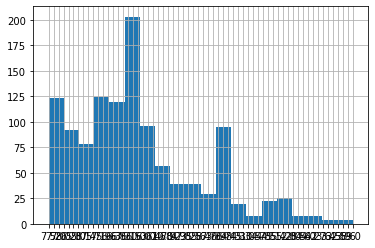

In [21]:
# How target variables are distributed
import matplotlib.pyplot as plt
post['vote_average'].hist(bins=20);

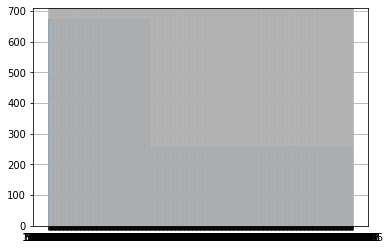

In [22]:
post['TMDB_revenue'].hist(bins=3)

In [24]:
data = data_dtm.transpose()
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191
aa,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
aaa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aaaa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aaaaa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aaaaaa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Find the top 3 words for each movie
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(3)
    top_dict[c]= list(zip(top.index, top.values))
top_dict

{0: [('kat', 409), ('patrick', 332), ('bianca', 266)],
 1: [('tony', 193), ('allen', 193), ('marienoel', 72)],
 2: [('jacob', 291), ('malee', 259), ('leonard', 229)],
 3: [('jacob', 291), ('malee', 259), ('leonard', 229)],
 4: [('solomon', 627), ('epps', 253), ('continued', 230)],
 5: [('solomon', 627), ('epps', 253), ('continued', 230)],
 6: [('aron', 259), ('cut', 255), ('canyon', 192)],
 7: [('columbus', 605), ('fernando', 117), ('ext', 108)],
 8: [('jordy', 467), ('emil', 391), ('eddie', 354)],
 9: [('jordy', 467), ('emil', 391), ('eddie', 354)],
 10: [('mike', 702), ('ed', 274), ('alex', 189)],
 11: [('hal', 108), ('floyd', 106), ('bowman', 95)],
 12: [('monty', 511), ('jakob', 219), ('continued', 204)],
 13: [('jim', 436), ('selena', 308), ('frank', 167)],
 14: [('dwayne', 362), ('chet', 338), ('jay', 153)],
 15: [('jack', 506), ('rickey', 347), ('rachel', 175)],
 16: [('colin', 264), ('archie', 206), ('mal', 178)],
 17: [('cates', 654), ('hammond', 405), ('ganz', 200)],
 18: [('

In [26]:
# Print the top 3 words for each movie
for movie, top_words in top_dict.items():
    print(movie)
    print(', '.join([word for word, count in top_words[0:3]]))
    print('---')

0
kat, patrick, bianca
---
1
tony, allen, marienoel
---
2
jacob, malee, leonard
---
3
jacob, malee, leonard
---
4
solomon, epps, continued
---
5
solomon, epps, continued
---
6
aron, cut, canyon
---
7
columbus, fernando, ext
---
8
jordy, emil, eddie
---
9
jordy, emil, eddie
---
10
mike, ed, alex
---
11
hal, floyd, bowman
---
12
monty, jakob, continued
---
13
jim, selena, frank
---
14
dwayne, chet, jay
---
15
jack, rickey, rachel
---
16
colin, archie, mal
---
17
cates, hammond, ganz
---
18
welles, int, eddie
---
19
machine, looks, contd
---
20
machine, looks, contd
---
21
kaffee, jo, sam
---
22
abel, anna, andrew
---
23
billy, billys, int
---
24
lee, marcus, regan
---
25
arctor, bob, barris
---
26
larry, danny, arthur
---
27
nico, jackson, nicos
---
28
nico, jackson, nicos
---
29
luther, seth, sullivan
---
30
carrey, detective, shadyac
---
31
wade, jack, jill
---
32
wade, jack, jill
---
33
wade, jack, jill
---
34
wade, jack, jill
---
35
deacon, fred, matt
---
36
anna, eliot, paul
---
37


Some of them have very little meaning and could be added to a stop words list

In [27]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each movie
words = []
for movie in data.columns:
    top = [word for (word, count) in top_dict[movie]]
    for t in top:
        words.append(t)
        
words

['kat',
 'patrick',
 'bianca',
 'tony',
 'allen',
 'marienoel',
 'jacob',
 'malee',
 'leonard',
 'jacob',
 'malee',
 'leonard',
 'solomon',
 'epps',
 'continued',
 'solomon',
 'epps',
 'continued',
 'aron',
 'cut',
 'canyon',
 'columbus',
 'fernando',
 'ext',
 'jordy',
 'emil',
 'eddie',
 'jordy',
 'emil',
 'eddie',
 'mike',
 'ed',
 'alex',
 'hal',
 'floyd',
 'bowman',
 'monty',
 'jakob',
 'continued',
 'jim',
 'selena',
 'frank',
 'dwayne',
 'chet',
 'jay',
 'jack',
 'rickey',
 'rachel',
 'colin',
 'archie',
 'mal',
 'cates',
 'hammond',
 'ganz',
 'welles',
 'int',
 'eddie',
 'machine',
 'looks',
 'contd',
 'machine',
 'looks',
 'contd',
 'kaffee',
 'jo',
 'sam',
 'abel',
 'anna',
 'andrew',
 'billy',
 'billys',
 'int',
 'lee',
 'marcus',
 'regan',
 'arctor',
 'bob',
 'barris',
 'larry',
 'danny',
 'arthur',
 'nico',
 'jackson',
 'nicos',
 'nico',
 'jackson',
 'nicos',
 'luther',
 'seth',
 'sullivan',
 'carrey',
 'detective',
 'shadyac',
 'wade',
 'jack',
 'jill',
 'wade',
 'jack',
 '

In [28]:
# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('continued', 101),
 ('jack', 37),
 ('cut', 31),
 ('int', 30),
 ('contd', 29),
 ('sam', 20),
 ('day', 20),
 ('david', 20),
 ('charlie', 20),
 ('jane', 19),
 ('mrs', 19),
 ('jake', 18),
 ('paul', 17),
 ('dont', 16),
 ('harry', 16),
 ('amy', 16),
 ('beast', 16),
 ('peter', 16),
 ('alex', 15),
 ('im', 15),
 ('joe', 15),
 ('ben', 14),
 ('nick', 14),
 ('adam', 14),
 ('mary', 13),
 ('john', 13),
 ('belle', 13),
 ('gaston', 13),
 ('ray', 13),
 ('frank', 12),
 ('rachel', 12),
 ('anna', 12),
 ('lisa', 12),
 ('tony', 11),
 ('looks', 11),
 ('bob', 11),
 ('steve', 11),
 ('shot', 11),
 ('chris', 11),
 ('just', 11),
 ('mr', 11),
 ('sidney', 11),
 ('jim', 10),
 ('jay', 10),
 ('billy', 10),
 ('like', 10),
 ('rick', 10),
 ('walter', 10),
 ('max', 10),
 ('jacob', 9),
 ('jill', 9),
 ('matt', 9),
 ('george', 9),
 ('bud', 9),
 ('jeff', 9),
 ('helen', 9),
 ('dan', 9),
 ('sarah', 9),
 ('parker', 9),
 ('rochester', 9),
 ('solomon', 8),
 ('eddie', 8),
 ('mike', 8),
 ('karen', 8),
 ('willie', 8),
 ('todd', 8),

In [29]:
# If more than half of the movies have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > 10]
add_stop_words

['continued',
 'jack',
 'cut',
 'int',
 'contd',
 'sam',
 'day',
 'david',
 'charlie',
 'jane',
 'mrs',
 'jake',
 'paul',
 'dont',
 'harry',
 'amy',
 'beast',
 'peter',
 'alex',
 'im',
 'joe',
 'ben',
 'nick',
 'adam',
 'mary',
 'john',
 'belle',
 'gaston',
 'ray',
 'frank',
 'rachel',
 'anna',
 'lisa',
 'tony',
 'looks',
 'bob',
 'steve',
 'shot',
 'chris',
 'just',
 'mr',
 'sidney']

In [30]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = data_clean2

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.script)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
#import pickle
#pickle.dump(cv, open("cv_stop.pkl", "wb"))
#data_stop.to_pickle("dtm_stop.pkl")

In [31]:
data_clean2.head()

,script
0,bbif window toptoplocationhreflocationhrefb bt...
1,scriptcut from blacktitle finexterior l...
2,...
3,...
4,years a slave ...


In [32]:
# WordClouds of most common words 
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

ValueError: ignored

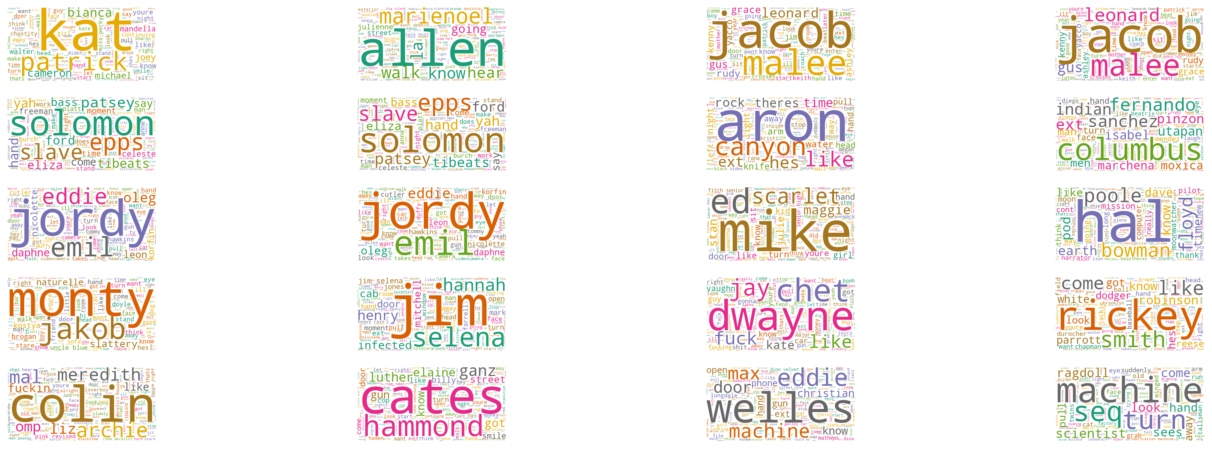

In [33]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 24, 8

#genres = ['1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']           

# Create subplots for each movie
for index, movie in enumerate(data.columns):
    wc.generate(data_clean.script[movie])
    
    plt.subplot(5, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    #plt.title(genres[index])
    
plt.show()

In [34]:
# Let's take a look at the most common words again.
Counter(words).most_common()

[('continued', 101),
 ('jack', 37),
 ('cut', 31),
 ('int', 30),
 ('contd', 29),
 ('sam', 20),
 ('day', 20),
 ('david', 20),
 ('charlie', 20),
 ('jane', 19),
 ('mrs', 19),
 ('jake', 18),
 ('paul', 17),
 ('dont', 16),
 ('harry', 16),
 ('amy', 16),
 ('beast', 16),
 ('peter', 16),
 ('alex', 15),
 ('im', 15),
 ('joe', 15),
 ('ben', 14),
 ('nick', 14),
 ('adam', 14),
 ('mary', 13),
 ('john', 13),
 ('belle', 13),
 ('gaston', 13),
 ('ray', 13),
 ('frank', 12),
 ('rachel', 12),
 ('anna', 12),
 ('lisa', 12),
 ('tony', 11),
 ('looks', 11),
 ('bob', 11),
 ('steve', 11),
 ('shot', 11),
 ('chris', 11),
 ('just', 11),
 ('mr', 11),
 ('sidney', 11),
 ('jim', 10),
 ('jay', 10),
 ('billy', 10),
 ('like', 10),
 ('rick', 10),
 ('walter', 10),
 ('max', 10),
 ('jacob', 9),
 ('jill', 9),
 ('matt', 9),
 ('george', 9),
 ('bud', 9),
 ('jeff', 9),
 ('helen', 9),
 ('dan', 9),
 ('sarah', 9),
 ('parker', 9),
 ('rochester', 9),
 ('solomon', 8),
 ('eddie', 8),
 ('mike', 8),
 ('karen', 8),
 ('willie', 8),
 ('todd', 8),

In [ ]:
# Preprocessing for numerical data
#numeric_transformer = Pipeline(steps=[
 #       ('imputer', SimpleImputer(strategy='median')),
  #      ('scaler', RobustScaler())])

# Preprocessing for categorical data
#categorical_transformer = Pipeline(steps=[
 #       ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
  #      ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Bundle preprocessing for numerical and categorical data
#preprocessor = ColumnTransformer(
 #   transformers=[
  #                ('num', numeric_transformer, numerical_cols),
   #               ('cat', categorical_transformer, categorical_cols)])

In [35]:
#Separate target from predictors
X_data = data_clean2['script'].fillna('most_frequent')
y_data = post[y_columns].fillna('median')

#The Model

## Revenue Model

In [42]:
X_data_reg =  post ['budget']
y_data_reg = post['TMDB_revenue']
#y_data_reg = post['TMDB_revenue'].values.reshape(-1,1)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_reg, y_data_reg, test_size=0.20, random_state=42)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(max_depth=2, random_state=0)

# Create linear regression object 
# regressor = LinearRegression() Score 0.4483

In [45]:
#regressor.fit(X_train, y_train)
regressor.fit(X_train[:,None], y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [46]:
y_pred = regressor.predict(X_test[:,None])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [47]:
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
score

0.5971108700202763

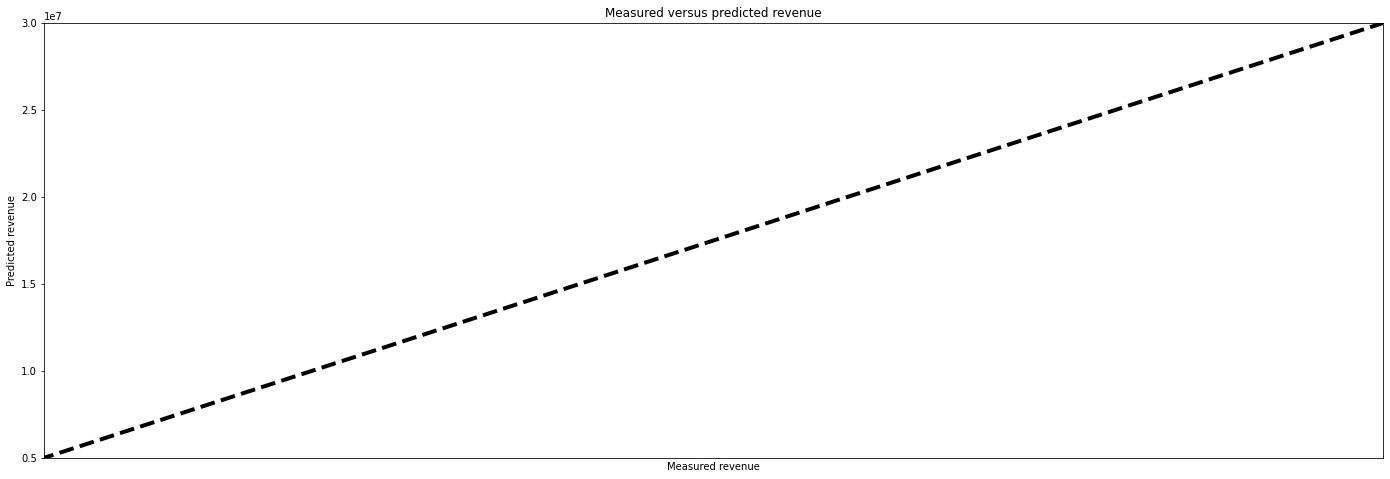

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=4)
ax.set_xlabel('Measured revenue')
ax.set_ylabel('Predicted revenue')
plt.title('Measured versus predicted revenue')
plt.ylim((5000000, 30000000))   # set the ylim to bottom, top
plt.xlim(5000000, 30000000)     # set the ylim to bottom, top
plt.show()

## Rating Model

In [49]:
X_data_clf = data_clean2 ['script']
y_data_clf = post['vote_average']

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(X_data_clf, y_data_clf, test_size=0.20, random_state=42)

# Validation & Demo set???
# - Row numbers x to y saved  a dataframe .txt file

In [51]:
lst = X_train.tolist()

In [52]:
vectorizer = TfidfVectorizer(
input = list ,  # input is the actual text
)
X_train = vectorizer.fit_transform(lst) #gives tf idf vector for x_train
X_test  = vectorizer.transform(X_test) #gives tf idf vector for x_test

In [53]:
from sklearn.naive_bayes import MultinomialNB
# train the model
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)